In [1]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.8 MB/s eta 0:00:00ta 0:00:01
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.8
    Uninstalling Cython-3.0.8:
      Successfully uninstalled Cython-3.0.8


In [2]:
import os
import torch
from torch import nn
import numpy as np

import matplotlib.pyplot as plt

from hdbscan import HDBSCAN

from tqdm import tqdm


In [3]:
class Clustering:
    def __init__(self, embeddings, min_cluster_size, min_samples):
        self.embeddings = embeddings
        self.clusterer = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        
    def cluster(self):
        cluster_labels = self.clusterer.fit_predict(self.embeddings)
        
        clusters = [i for i in list(set(cluster_labels)) if i!= -1]
        n_clusters = len(clusters)
        n_noise = list(cluster_labels).count(-1)
        
        
        return cluster_labels, n_clusters, n_noise
        

In [4]:
embeddings = np.load("/kaggle/input/forex-images-vgg-embeddings/umap_embedding_projection.npy")

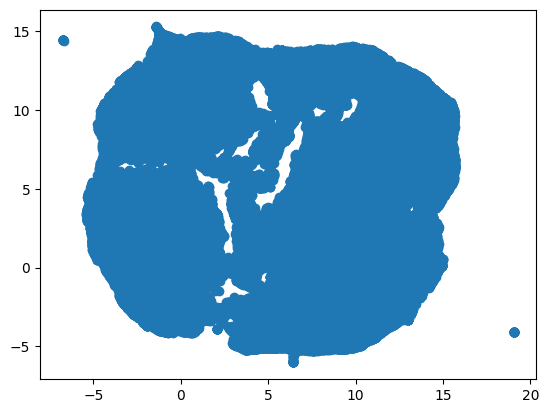

In [5]:
plt.scatter(embeddings[:, 0], embeddings[:, 1])

In [50]:
clustering = Clustering(embeddings, min_cluster_size=1000, min_samples=7)

In [51]:
cluster_labels, n_clusters, n_noise = clustering.cluster()

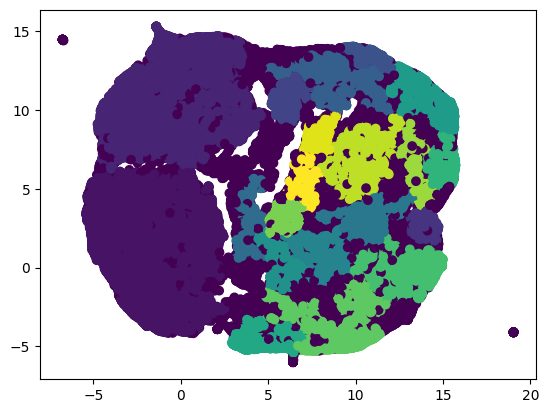

In [52]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=cluster_labels)

In [54]:
n_clusters

20

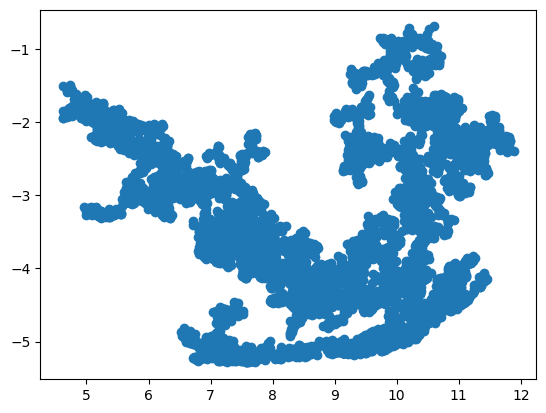

In [88]:
plt.scatter(embeddings[cluster_labels==14][:, 0], embeddings[cluster_labels==14][:, 1])

In [64]:
class RecursiveClustering:
    def __init__(self, embeddings, max_depth=3, min_cluster_size=1000, min_samples=7):
        self.embeddings = embeddings
        self.max_depth = max_depth
        
        self.min_cluster_size = min_cluster_size
        self.min_samples = min_samples
    
    def cluster_once(self, embeddings):
        clusterer = Clustering(embeddings, min_cluster_size=self.min_cluster_size, min_samples=self.min_samples)
        cluster_labels, n_clusters, n_noise = clusterer.cluster()
        return cluster_labels, n_clusters, n_noise
    
    def recursive(self, depth, embeddings):
        if depth == 0 or embeddings.shape[0] <= 2000:
            # cluster for the final time
            labels, num_clusters, num_noise = self.cluster_once(embeddings)
            
            results = {
                "depth": depth,
                "labels": labels,
                "num_clusters": num_clusters,
                "num_noise": num_noise,
                "subclusters": None
            }
            
            return results
        else:
            
            labels, num_clusters, num_noise = self.cluster_once(embeddings)
            
            results = {
                "depth": depth,
                "labels": labels,
                "num_clusters": num_clusters,
                "num_noise": num_noise,
                "subclusters": {}
            }
            
            for cluster in tqdm(range(num_clusters)):
                results["subclusters"][cluster] = self.recursive(depth - 1, embeddings[labels == cluster])
            
            return results
            
        
    def run(self):
        results = self.recursive(self.max_depth, self.embeddings)
        return results

In [65]:
recursive_clusterer = RecursiveClustering(embeddings, max_depth=2)

In [66]:
recursive_clustering_results = recursive_clusterer.run()

 10%|█         | 2/20 [00:01<00:17,  1.03it/s]
0it [00:00, ?it/s]
 30%|███       | 6/20 [00:02<00:03,  3.83it/s]
0it [00:00, ?it/s]
 40%|████      | 8/20 [00:02<00:02,  5.27it/s]
0it [00:00, ?it/s]
 50%|█████     | 10/20 [00:02<00:01,  6.89it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]
 60%|██████    | 12/20 [00:02<00:00,  8.24it/s]
0it [00:00, ?it/s]
 80%|████████  | 16/20 [00:03<00:00,  7.59it/s]
0it [00:00, ?it/s]
100%|██████████| 20/20 [00:03<00:00,  6.11it/s]


## The Two big clusters on the left are of index 0 and 1. So we're interested in finding out the sub-clusters of these two clusters.

In [87]:
recursive_clustering_results["subclusters"]

{0: {'depth': 1,
  'labels': array([ 1,  1,  1, ..., -1, -1,  0]),
  'num_clusters': 4,
  'num_noise': 7720,
  'subclusters': {0: {'depth': 0,
    'labels': array([-1, -1, -1, ..., -1, -1, -1]),
    'num_clusters': 0,
    'num_noise': 2166,
    'subclusters': None},
   1: {'depth': 0,
    'labels': array([-1, -1, -1, ..., -1, -1, -1]),
    'num_clusters': 0,
    'num_noise': 3875,
    'subclusters': None},
   2: {'depth': 0,
    'labels': array([1, 1, 1, ..., 1, 0, 1]),
    'num_clusters': 2,
    'num_noise': 1878,
    'subclusters': None},
   3: {'depth': 0,
    'labels': array([-1, -1, -1, ..., -1, -1, -1]),
    'num_clusters': 0,
    'num_noise': 1424,
    'subclusters': None}}},
 1: {'depth': 1,
  'labels': array([ 1, -1,  1, ...,  1,  1,  1]),
  'num_clusters': 2,
  'num_noise': 1192,
  'subclusters': {0: {'depth': 0,
    'labels': array([-1, -1, -1, ..., -1, -1, -1]),
    'num_clusters': 0,
    'num_noise': 2865,
    'subclusters': None},
   1: {'depth': 0,
    'labels': array([ 

In [90]:
recursive_clustering_results["subclusters"][0]

{'depth': 1,
 'labels': array([ 1,  1,  1, ..., -1, -1,  0]),
 'num_clusters': 4,
 'num_noise': 7720,
 'subclusters': {0: {'depth': 0,
   'labels': array([-1, -1, -1, ..., -1, -1, -1]),
   'num_clusters': 0,
   'num_noise': 2166,
   'subclusters': None},
  1: {'depth': 0,
   'labels': array([-1, -1, -1, ..., -1, -1, -1]),
   'num_clusters': 0,
   'num_noise': 3875,
   'subclusters': None},
  2: {'depth': 0,
   'labels': array([1, 1, 1, ..., 1, 0, 1]),
   'num_clusters': 2,
   'num_noise': 1878,
   'subclusters': None},
  3: {'depth': 0,
   'labels': array([-1, -1, -1, ..., -1, -1, -1]),
   'num_clusters': 0,
   'num_noise': 1424,
   'subclusters': None}}}

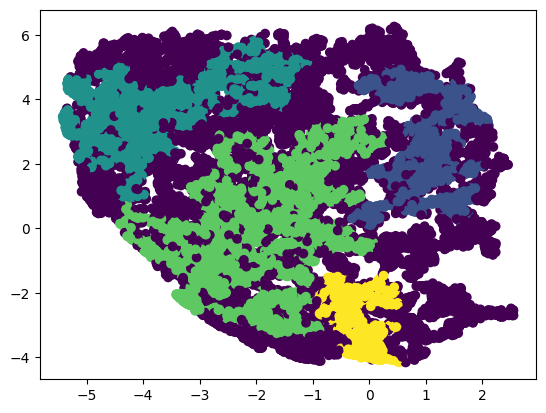

In [94]:
plt.scatter(embeddings[cluster_labels==0][:, 0], embeddings[cluster_labels==0][:, 1], c=recursive_clustering_results["subclusters"][0]["labels"])

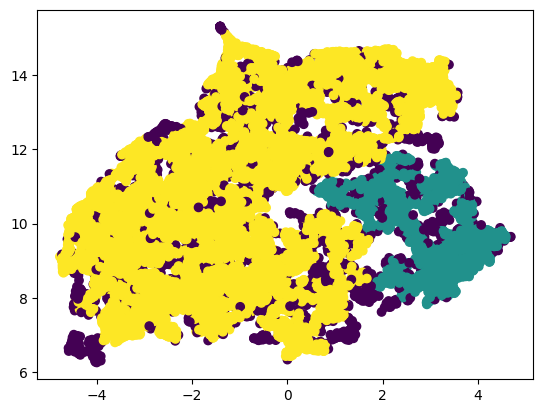

In [95]:
plt.scatter(embeddings[cluster_labels==1][:, 0], embeddings[cluster_labels==1][:, 1], c=recursive_clustering_results["subclusters"][1]["labels"])

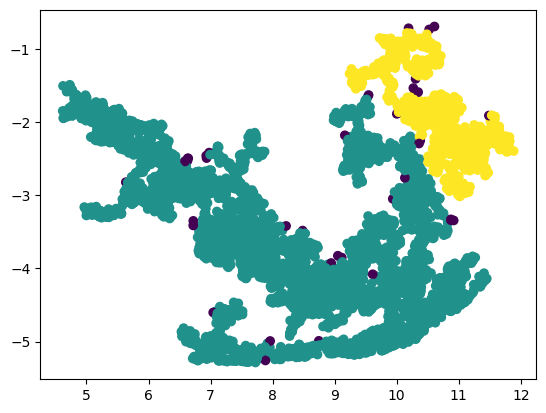

In [96]:
plt.scatter(embeddings[cluster_labels==14][:, 0], embeddings[cluster_labels==14][:, 1], c=recursive_clustering_results["subclusters"][14]["labels"])

In [124]:
new_labels = {
    "0": [f"0{r}" if r!=-1 else -1 for r in recursive_clustering_results["subclusters"][0]["labels"]],
    "1": [f"1{r}" if r!=-1 else -1 for r in recursive_clustering_results["subclusters"][1]["labels"]],
    "14": [f"14{r}" if r!=-1 else -1 for r in recursive_clustering_results["subclusters"][14]["labels"]]
}

In [125]:
len(new_labels["0"])

21417

In [126]:
len(new_labels["1"])

18612

In [127]:
recursive_clustering_results["labels"][recursive_clustering_results["labels"] == 0]

array([0, 0, 0, ..., 0, 0, 0])

In [128]:
clustering_results_labels = recursive_clustering_results["labels"].copy().astype(object)

In [129]:
clustering_results_labels

array([10, 0, 0, ..., 0, 1, 1], dtype=object)

In [130]:
clustering_results_labels[clustering_results_labels == 0] = new_labels["0"]

In [131]:
clustering_results_labels[clustering_results_labels == 1] = new_labels["1"]

In [132]:
clustering_results_labels[clustering_results_labels == 14] = new_labels["14"]

In [133]:
set(clustering_results_labels)

{-1,
 '00',
 '01',
 '02',
 '03',
 10,
 '10',
 11,
 '11',
 12,
 13,
 '140',
 '141',
 15,
 16,
 17,
 18,
 19,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9}

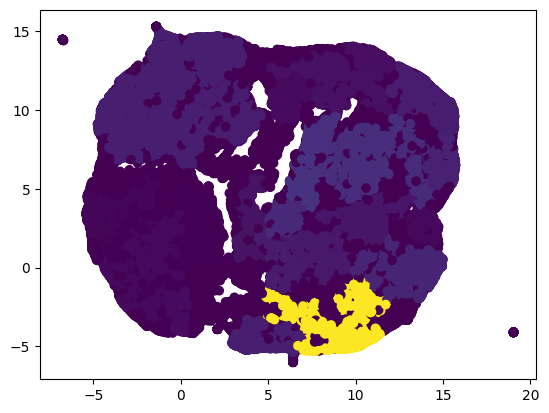

In [137]:
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=clustering_results_labels)

In [139]:
np.save("recursive_clustering_results.npy", recursive_clustering_results)
np.save("clustering_results_labels.npy", clustering_results_labels)

# Next steps:
1. Use the cluster labels from today to develop a dataset
2. Train Simple model to accurately classify the embeddings into the cluster classes
3. Iteratively label the rest of the unlabelled images

# Further steps:
1. Do an analysis of a single currency pair by converting the time-series into a sequence of tokens by pattern mining.
2. Explore the possibility of doing a high level pattern-mining search by converting other pairs.